#Application: Image Search

In [96]:
%matplotlib inline
import cv2
import whoosh_ as who
import itertools
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import scipy.sparse as sp
from scipy.stats import scoreatpercentile
import time

## Creating feature vectors from image data

Our goal is to create a feature vector that describes an image so that we may use our nearest neighbour approximation algorithm to quickly find similar images. 

This is accomplished by taking pixels, each with their three RGB values, and placing them in their nearest colour bin, created by dividing up the colour space, where the centre of each bin is the position of the bin. Once each pixel is binned, the count in each bin leaves us with a histogram. The histogram heights are our feature vector values.

After some experimentation, HSV colour space revealed itself to be an accessible and quality option as it captures certain colours, like yellow, better than RGB. As can be seen in the image below, there is a large portion devoted to all of the different yellows. 

We provide the option of three different bin counts (32, 64, 128), to examine the performance of the algorithm and the of the application under different circumstances. 

In [97]:
from IPython.display import Image
Image(filename='/home/treimer/src/dsearch/ipy/HSV.png', width = 600)

In [98]:
def gen_centres(A_bins, B_bins, C_bins):
    '''divides up HSV colour space into bins and returns an RGB colour of center of each bin'''
    A_centres = []
    for i in range(0, A_bins):
        A_centre = i/float(A_bins) + 1/(2*float(A_bins))
        A_centres.append(A_centre)
    B_centres = []
    for i in range(0, B_bins):
        B_centre = i/float(B_bins) + 1/(2*float(B_bins))
        B_centres.append(B_centre)
    C_centres = []
    for i in range(0, C_bins):
        C_centre = i/float(C_bins) + 1/(2*float(C_bins))
        C_centres.append(C_centre)
    
    centres = np.array(list((itertools.product(A_centres, B_centres, C_centres))))
    centres[:,1:3] = 255*centres[:,1:3]
    centres[:,0] = 179*centres[:,0]
    centres = np.array(centres, np.uint8)
    centres_HSV =  centres.reshape((1, len(centres),3))
    centres_RGB = cv2.cvtColor(centres_HSV, cv2.COLOR_HSV2RGB)
    centre_colours = centres_RGB.reshape(-1,3)/255.0
    return centre_colours

def get_image(archive_nb, image_nb, type_): 
    img = cv2.imread('/var/data/imageclef/images/{}/{}.jpg'.format(archive_nb, image_nb))
    if type_ == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)    
    elif type_ == 'RGB':
        img = img[:,:,::-1]    
    else:
        print "You have not entered 'RGB' or 'HSV'."
    return img

def gen_hist(archive, img_nb, nb_bins):  
    img = get_image(archive, img_nb, 'HSV')
    
    if nb_bins == 32:
        i,j,k = 8,1,4
    elif nb_bins == 64:
        i,j,k = 8,2,4
    elif nb_bins == 128:
        i,j,k = 8,4,4
    else:
        print 'Please enter 32, 62, or 128.'
        
    centre_colours_RGB = gen_centres(i,j,k)
    hist = cv2.calcHist( [img], [2, 1, 0], None, [k, j, i], [0, 256, 0, 256, 0, 180] ).transpose().ravel()
    
    plt.figure(figsize=(8, 6))
    #plt.bar(np.arange(nb_bins), np.ones(nb_bins), color=centre_colours_RGB) # for making reference hist
    plt.bar(np.arange(nb_bins), hist, color=centre_colours_RGB)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))
    yt = plt.yticks()[0]
    plt.yticks(yt, [' '] * len(yt))
    plt.xlim(0, nb_bins)
    return hist

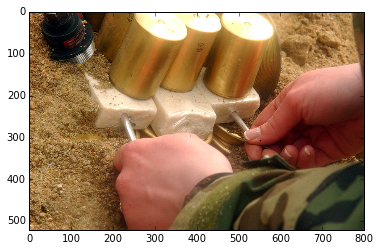

In [99]:
test_img = get_image(1, 1, 'RGB')
plt.imshow(test_img) #takes BGR values
plt.show()

In [101]:
test_hist = gen_hist(1, 1, 64)
plt.show()

## Data Storage

To easily save data so that we may make experimentation quicker, we generate all of the histograms and store them in a .json file. The image number acts as the data key. 

This is demonstrated below and does take a significant amount of time. 

In [102]:
def create_corpus(nb_images):
    image_list = []
    for i in range(1,nb_images):
        archive_nb = int(i/10000)+1
        try:
            img = get_image(archive_nb,i, 'HSV')
            image_list.append(i)
        except:
            pass 
    return image_list

def gen_hists(corpus, bins):
    histograms = []
    for i in corpus:
        archive_nb = int(i/10000)+1
        hist = gen_hist(archive_nb, i, bins)
        histograms.append(hist.astype(int))
        plt.clf()
        plt.close()
    return histograms

def create_json(keys, data, directory_filename):
    histogram_archive = {}
    for k,h in zip(keys,data):
        h_as_list = tuple(h)
        histogram_archive[k] = h_as_list
    
    with open(directory_filename, 'w') as outfile:
        json.dump((histogram_archive), outfile,indent = 4)
    return

In [ ]:
json_file = '/var/data/imageclef/histograms/test_64_.json'
corpus = create_corpus(10000) #just a sample for time's sake
hists = gen_hists(corpus, 64) #this step takes quite a while
create_json(corpus, hists, json_file)

## Data summary
Now that our data is saved, we can access it anytime without having to recreate it. 

To demonstrate the difference in the two datasets used, dow and image data, we decompose a sample of the dataset.

This is performed with the Singular Value Decompostion. We then take the first two unitary vectors and project our data onto them, providing us with an (x,y) for each vector. 

In [ ]:
json_file = '/var/data/imageclef/histograms/test_64_.json'
json_data=open(json_file)
data = json.load(json_data)
json_data.close()

n = 64
corpus_size = len(data.keys())
X = np.zeros((corpus_size,n))

for j in range(0, corpus_size):
    X[j] = data['{}'.format(int(data.keys()[j]))]
    
norms = np.linalg.norm(X, ord=None, axis=1)
X = X/norms[:,np.newaxis]

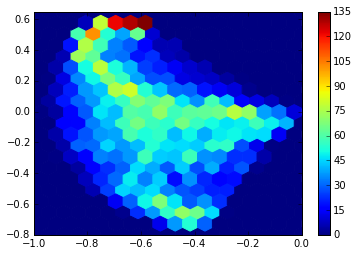

In [119]:
#Memory error if sample is too big
u, s, v = np.linalg.svd(X.transpose())
u_ = u[:,0:2]

projections = []
for vec in X:
    projections.append(np.dot(vec, u_))
    
projections = np.array(projections)
x = projections[:,0]
y = projections[:,1]

plt.hexbin(x, y, gridsize = 18, cmap = 'jet', extent=[-1, 0, -0.8, 0.65] ) 
plt.colorbar()
plt.show()

## Nearest Neighbours

In [106]:
def display_matches(matches):
    '''currently configured nicely for 15 results'''
    nb_results = len(matches)
    n_rows = int((nb_results/5.0)+0.999) 
    fig, ax = plt.subplots(nrows=n_rows, ncols= 5, figsize = (15,10)) 
    for i, match in enumerate(matches):
        x = i/5
        y = int(round((i/5.0 - i/5)*5))
        img = get_image(1, match, 'RGB')
        ax[x, y].imshow(img)
        ax[x, y].set_xticklabels([])
        ax[x, y].set_yticklabels([])
        ax[x, y].set_yticks([])
    plt.show()
    return

In [121]:
json_file = '/var/data/imageclef/histograms/test_64_.json'

img = '1'
params = {'d': 64, 'm': 32000, 'r': 0.2, 'r2': 0.2,}

index_dir = '/home/treimer/var/data/whoosh_indexes/test_app64_/'
if not os.path.exists(index_dir):
    os.makedirs(index_dir)
    who.index_json(json_file, params, 'gaussian', index_dir)
    
matches, search_times = who.search(img, json_file, params, 'gaussian', index_dir, 15)
display_matches(matches)

## Precision vs. Recall
A standard of the literature, we use our nearest neighbours approximation algorithm to calculate the precision and recall scores for our image data. 

Precision and recall are defined as follows:

$$
       precision = \frac{retrieved \cap relevant}{retrieved} $$
        
$$
       recall = \frac{retrieved \cap relevant}{relevant} $$
        

An image is retrieved if our given score is getter than some threshold T. An image is relevant if its true score is greater than some desired threshold, $ \lambda $.


In [130]:
def find_precision_recall(scores, T, true_scores, lambda_):
    retrieved = 0
    relevant = 0
    retrieved_and_relevant = 0
    for i in range(0, len(scores)):
        
        if scores[i] > T:
            retrieved += 1
            retrieved_ = True    
        else:
            retrieved_ = False
        
        if true_scores[i] > lambda_:
            relevant += 1
            relevant_ = True
        else:
            relevant_ = False
        
        if retrieved_ == True and relevant_ == True:
            retrieved_and_relevant += 1
            
    try:
        precision = retrieved_and_relevant/float(retrieved)    
    except:
        precision = 0 
    try:
        recall = retrieved_and_relevant/float(relevant)
    except:
        recall = 0
        
    return precision, recall

def ref_pts(recall, precision, t_range):
    for i,k in enumerate(zip(recall, precision)):
        if recall[i] == 1.0:
            pt1 = [k, t_range[i]]
        if precision[i] == 1.0:
            pt2 = [k, t_range[i]]
            break
    return pt1, pt2

def index_corpus(X, A, h):
    ''' index the corpus documents, producing a Boolean matrix                                                                                                            
    A is the nb_dimensions x m random projection matrix'''
    Y = np.dot(X, A)
    Ybool = sp.csr_matrix(np.where(Y>h, 1, 0))                                                                                                             
    Ybool.eliminate_zeros()                                                                                                                                               
    return Ybool 

def generate_projection_matrix(document_dimension, m, random_seed=None):
    if random_seed: np.random.seed(random_seed)                                                                                                                           
    return np.random.randn(document_dimension, m) 

In [24]:
lambda_ = 0.80
m = 30000
r = 0.2
h = np.sqrt(2*r*np.log(m))
nb_iter = 300
step = 0.01
t_range = np.arange(0.2, 0.9, step)
A = generate_projection_matrix(X.shape[1], m)
I = index_corpus(X,A,h)

precision, recall, precision_std, recall_std = [], [], [], []

for T in t_range:
    iter_precision, iter_recall = [], []
    
    for i in range(0,nb_iter):
        
        q_index = random.choice(range(X.shape[0]))

        scores_list = I.dot(I[q_index].transpose()).todense()
        scores_list = scores_list/float(max(scores_list))

        true_scores = np.dot(X, X[q_index])

        prec_, rec_ = find_precision_recall(scores_list, T, true_scores, lambda_)

        iter_precision.append(prec_)
        iter_recall.append(rec_)
        
    precision.append(np.mean(iter_precision))
    recall.append(np.mean(iter_recall))
    precision_std.append(np.std(iter_precision))
    recall_std.append(np.std(iter_recall))

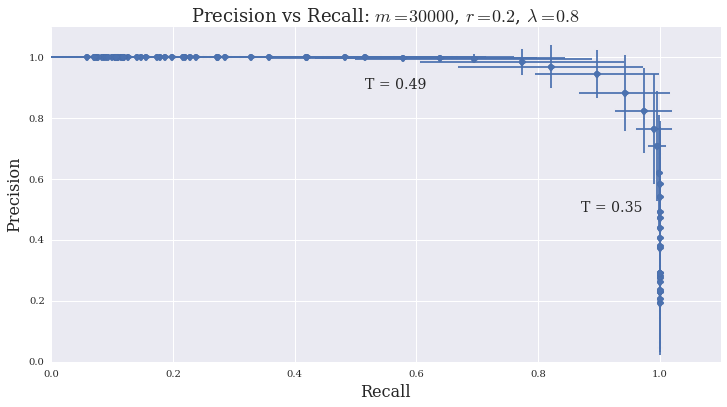

In [26]:
import seaborn as sns
plt.rc('font', family='serif', size=16)
fig,ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel(r'Recall', fontsize=16)
ax.set_ylabel(r'Precision', fontsize=16)
ax.set_title(r'Precision vs Recall: $m = {}$, $r = {}$, $\lambda = {}$'.format(m, r, lambda_), fontsize=18)

plt.errorbar(recall, precision, xerr = recall_std , yerr= precision_std, fmt='o')

plt.ylim(0, 1.1)
plt.xlim(0, 1.1)

# to add reference points
pt1, pt2 = ref_pts(recall, precision, t_range)
plt.text(pt1[0][0]-0.13, pt1[0][1], r'T = {}'.format(pt1[1]), fontsize = 14)
plt.text(pt2[0][0], pt2[0][1]-0.1, r'T = {}'.format(pt2[1]), fontsize = 14)
ax.legend() 

## Change to search time for change of vector dimension

In [74]:
search_times = []
dims = [32, 64, 128]
for d in dims:
    nb_iters = 300
    m = 30000
    params = {'d': d, 'm': m, 'h1': 3.1, 'h2': 3.3,}
    
    json_file='/var/data/imageclef/histograms/histo_{}_13.json'.format(d)
    index_dir = '/home/treimer/var/data/econ_indexes/matching_{}_{}_13/'.format(d, m)
    if not os.path.exists(index_dir):
        os.makedirs(index_dir)
        who.index_json(json_file, params, 'gaussian', index_dir)
    
    iter_search_times = []    
    for i in range(nb_iters):
        try:
            query = '{}'.format(i)
            results, search_time = who.search(query, json_file, params, 'gaussian', index_dir, 15)
            iter_search_times.append(search_time)
        except:
            pass
        
    search_times.append(iter_search_times)

TypeError: 'float' object is not iterable

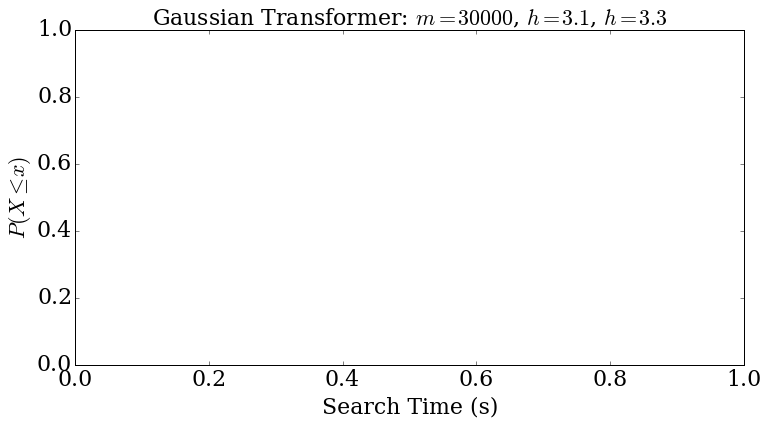

In [123]:
plt.rc('font', family='serif', size=22)
fig, ax = plt.subplots(figsize=(12,6))
plt.title(r'Gaussian Transformer: $m = 30000$, $h= 3.1$, $h = 3.3$', fontsize = 22)
plt.ylabel('$P(X\leq x)$', fontsize = 22)
plt.xlabel('Search Time (s)', fontsize = 22)

for i, x_ in enumerate(search_times):
    y_data = np.array(range(101))/100.0
    x_data = scoreatpercentile(x_, range(101))
    plt.plot(x_data, y_data, label = '{} bins'.format(dims[i]))

plt.xlim(0, 4)
ax.legend(loc='lower right')
plt.show() 